#Paludisme


Le paludisme est une maladie parasitaire potentiellement mortelle causée par une infection par un protozoaire Plasmodium transmis par un moustique anophèle femelle infectieux.

Le modèle suivant tente de distinguer les cellules infectées par le paludisme de celles qui ne le sont pas.

Répartition de ce TP :

* Chargement de l'ensemble de données : chargez les données et importez les bibliothèques.

* Prétraitement des données :
Lire les images, étiquettes stockées dans 2 dossiers (Parasitisés, Non infectés).

* Tracer les images non infectées et parasitées avec leurs étiquettes respectives.

* Normalisation des données d'image.
Entraînement, test fractionné
* Augmentation des données : augmentez les données d'entraînement et de validation à l'aide d'ImageDataGenerator
* Création et formation du modèle : créez un modèle cnn avec la bibliothèque  KERAS.

* Évaluation : affichez  les métriques d’évaluation et tracer la courbe.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


The dataset can be downloaded from https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

#Importation des Bibliothèques (Packages)

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import random

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

def prep_dataset(X,y):
    X_prep = X.astype('float32')
    y_prep = to_categorical(np.array(y))
    return (X_prep, y_prep)

In [ ]:
root = '/content/drive/MyDrive/'
para = '/TP_Paludisme/IA/cell_images/Parasitized/'
uninf = '/TP_Paludisme/IA/cell_images/Uninfected/'

os.listdir(root)

['Mongodb_mapReduce_SIMBA-Prince_Hadja-BAH.zip',
 'Benchmarks.gdoc',
 'Examen_PrinceSimba_et_HadjaBah.docx',
 'Fiches.gslides',
 'Portfolio - Graphique à secteurs 1.gsheet',
 'Portfolio.gslides',
 'CMS_Audios',
 'DW DIT2',
 '1.Introduction aux systèmes distribués ou systèmes répartis.gdoc',
 'CV_SP Septembre 22.pdf',
 'Colab Notebooks',
 'Kaggle_db',
 '.ipynb_checkpoints',
 'sample_data',
 'Save_models',
 'Meet Recordings',
 'TP_Paludisme',
 'taf_geomatique',
 'model_CNN']

#Visualisation des données

Nous examinons quelques exemples de cellules parasitées et non infectées.

In [ ]:
Parasitized = os.listdir(root+para)
Uninfected = os.listdir(root+uninf)

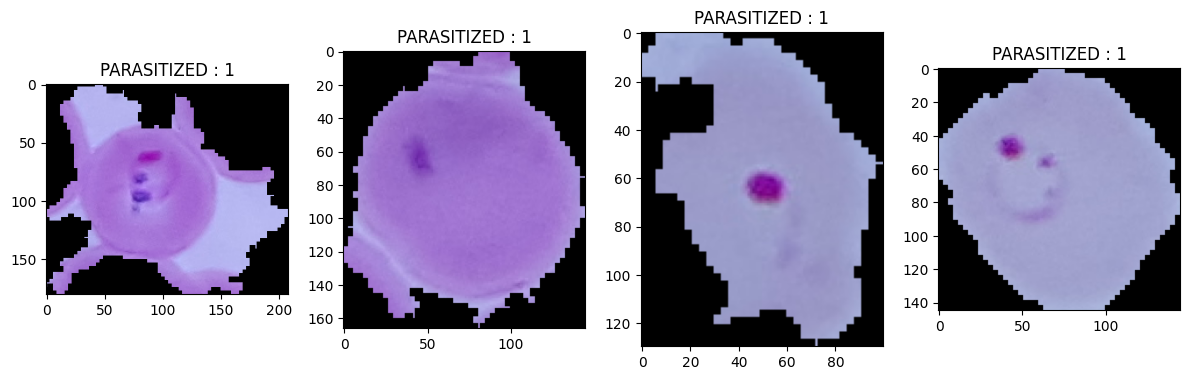

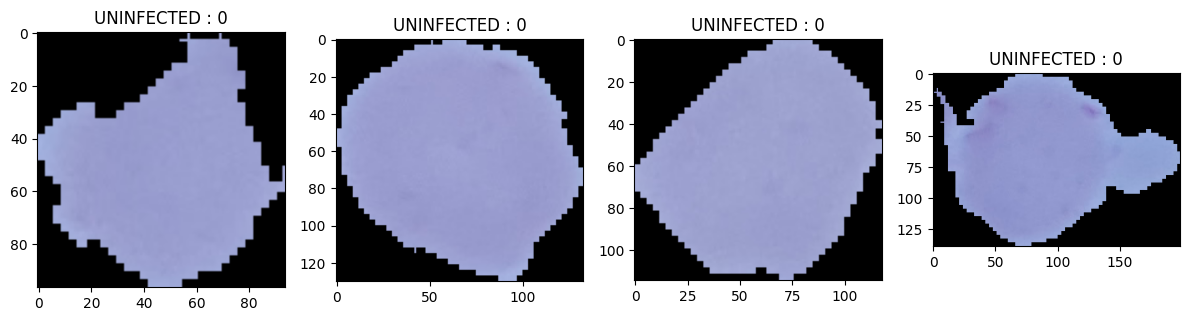

In [ ]:
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(root+para+ Parasitized[i])
    plt.imshow(img)
    plt.title('PARASITIZED : 1')
    plt.tight_layout()
plt.show()

plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(2, 4, i+1)
    img = cv2.imread(root+uninf+ Uninfected[i+1])
    plt.imshow(img)
    plt.title('UNINFECTED : 0')
    plt.tight_layout()
plt.show()

#Préparation des données


Les images sont redimensionnées et converties en tableaux avant d'être ajoutées dans une seule liste

In [ ]:
data = []
labels = []

for img in Parasitized:
    try:
        img_read = plt.imread(root+para+ img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(1)
    except:
        None

for img in Uninfected:
    try:
        img_read = plt.imread(root+uninf+ img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        None


#Visualiser les données prétraitées

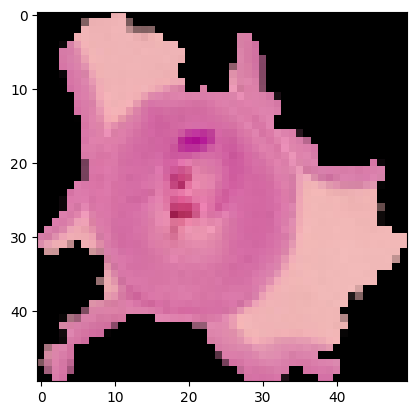

In [ ]:
plt.imshow(data[0], cmap='gray')
plt.show()

#Mélanger l'ensemble de données



L'ensemble de données contient d'abord les images de cellules parasitées, suivies des images des cellules non infectées. Afin de garantir de meilleures performances, l'ensemble de données est mélangé de manière aléatoire.

In [ ]:
image_data = np.array(data)
labels = np.array(labels)

idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

In [ ]:
image_data.shape

(27618, 50, 50, 3)

In [ ]:
labels.shape

(27618,)

In [ ]:
X, y = prep_dataset(image_data,labels)

#Répartition de l'ensemble de données


Les données traitées et mélangées sont désormais divisées en ensembles de formation, de validation et de test.

 Une répartition de 70 %-30 % est suivie

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.3, shuffle=True,stratify=y)
X_test, X_val, Y_test, Y_val = train_test_split(X_test,Y_test, test_size=0.5, stratify=Y_test)

Y_test = np.argmax(Y_test, axis=1)


## Recherche des hyperparams optimaux

In [ ]:
#hyperparam = {'activation':['relu','sigmoid','tanh'], 'optimizer':['adam','sgd']}

#Modèle CNN

Une approche modèle CNN est utilisée pour résoudre ce problème.

Le modèle utilise l'optimiseur Adam, la précision étant la métrique

In [ ]:
model = models.Sequential() #Sequential Model

#ConvLayer(64 filters) + MaxPooling + BatchNormalization + Dropout
model.add(layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',input_shape=X.shape[1:]))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

#ConvLayer(128 filters) + MaxPooling + BatchNormalization + Dropout
model.add(layers.Conv2D(filters=128,kernel_size=3,activation='relu',padding='same'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

#ConvLayer(128 filters) + MaxPooling + BatchNormalization + Dropout
model.add(layers.Conv2D(filters=128,kernel_size=3,activation='relu',padding='same'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

#ConvLayer(512 filters) + Dropout + ConvLayer(512 filters) + MaxPooling + BatchNormalization
model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same'))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

#Flatten
model.add(layers.Flatten())

#3 Dense layers with 4000 hidden units
model.add(layers.Dense(4000,activation='relu'))
model.add(layers.Dense(4000,activation='relu'))
model.add(layers.Dense(4000,activation='relu'))

#Dense layer with 1000 hidden units
model.add(layers.Dense(1000,activation='relu'))

#Softmax layer for output
model.add(layers.Dense(2,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 25, 25, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 128)       0

#Apprentissage  du modèle



Le modèle est entraîné pendant 10 époques avec une taille de lot de 64 en utilisant la précision comme métrique

In [ ]:
epochs=10
eval_every=5
batch_size=64
evaluation_size=500

In [ ]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

earlystopping = callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 3,restore_best_weights = True,verbose = 1)

history= model.fit(X_train,Y_train,
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(X_val,Y_val),
                 callbacks = [earlystopping])

Epoch 1/10
303/303 [==============================] - 992s 3s/step - loss: 0.4439 - accuracy: 0.8434 - val_loss: 2.4859 - val_accuracy: 0.5006
Epoch 2/10
303/303 [==============================] - 945s 3s/step - loss: 0.1706 - accuracy: 0.9460 - val_loss: 0.1550 - val_accuracy: 0.9527
Epoch 3/10
303/303 [==============================] - 939s 3s/step - loss: 0.1522 - accuracy: 0.9523 - val_loss: 0.1582 - val_accuracy: 0.9539
Epoch 4/10
303/303 [==============================] - 945s 3s/step - loss: 0.1432 - accuracy: 0.9552 - val_loss: 0.1414 - val_accuracy: 0.9592
Epoch 5/10
303/303 [==============================] - 948s 3s/step - loss: 0.1433 - accuracy: 0.9529 - val_loss: 0.1314 - val_accuracy: 0.9582
Epoch 6/10
303/303 [==============================] - 941s 3s/step - loss: 0.1421 - accuracy: 0.9549 - val_loss: 0.1796 - val_accuracy: 0.9537
Epoch 7/10
303/303 [==============================] - 945s 3s/step - loss: 0.1206 - accuracy: 0.9598 - val_loss: 0.1129 - val_accuracy: 0.9582

In [ ]:
#save model
#filepath ="/drive/MyDrive/TP_Paludisme/model_CNN"
model.save("model_CNN.h5")
model.save("model_CNN.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Plot the training history
plt.figure(figsize=(16, 8))
plt.subplhistoryot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epoch')

##Values metrics Entrainement du modele

In [ ]:
train_loss = []
train_acc = []
test_acc = []
for i in range(epochs):
    rand_index = np.random.choice(len(X_train), size=batch_size)
    rand_x = X_train[rand_index]
    rand_y = Y_train[rand_index]

    history_train = model.train_on_batch(rand_x, rand_y)

    if (i+1) % eval_every == 0:
        eval_index = np.random.choice(len(X_test), size=evaluation_size)
        eval_x = X_test[eval_index]
        eval_y = Y_test[eval_index]
        eval_y_one_hot = to_categorical(eval_y, num_classes=2)

        # Evaluate the model and store the loss and accuracy
        history_eval = model.evaluate(eval_x, eval_y_one_hot, verbose=0)
        test_acc.append(history_eval[1])

        # Record and print results
        train_loss.append(history_train[0])
        train_acc.append(history_train[1])
        # test_acc.append(history_eval[1])
        acc_and_loss = [(i+1), history_train[0], history_train[1], history_eval[1]]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Epoch # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Epoch # 5. Train Loss: 0.21. Train Acc (Test Acc): 0.91 (0.97)
Epoch # 10. Train Loss: 0.13. Train Acc (Test Acc): 0.94 (0.94)


The progress in training accuracy and validation accuracy is compared


In [ ]:
#fig, ax=plt.subplots(2,1,figsize=(12,10))
#fig.suptitle('Train evaluation')

#sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
#sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

#ax[0].legend(['Train','Validation'])
#ax[0].set_title('Accuracy')

#sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
#sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

#ax[1].legend(['Train','Validation'])
#ax[1].set_title('Loss')


In [ ]:
Y_pred = model.predict(X_test)

Y_pred = np.argmax(Y_pred, axis=1)

130/130 [==============================] - 41s 316ms/step


In [ ]:
# Affichage des Scores
cnn_test_score = accuracy_score(Y_test, Y_pred)

#print('accuracy train:', accuracy_score(y_multi_tr, pred))
print('accuracy predict test:', cnn_test_score)
print('f1-score:', f1_score(Y_test, Y_pred, average='weighted'))

#Prédiction

Ce modèle est utilisé pour prédire les valeurs dans l'ensemble de test.

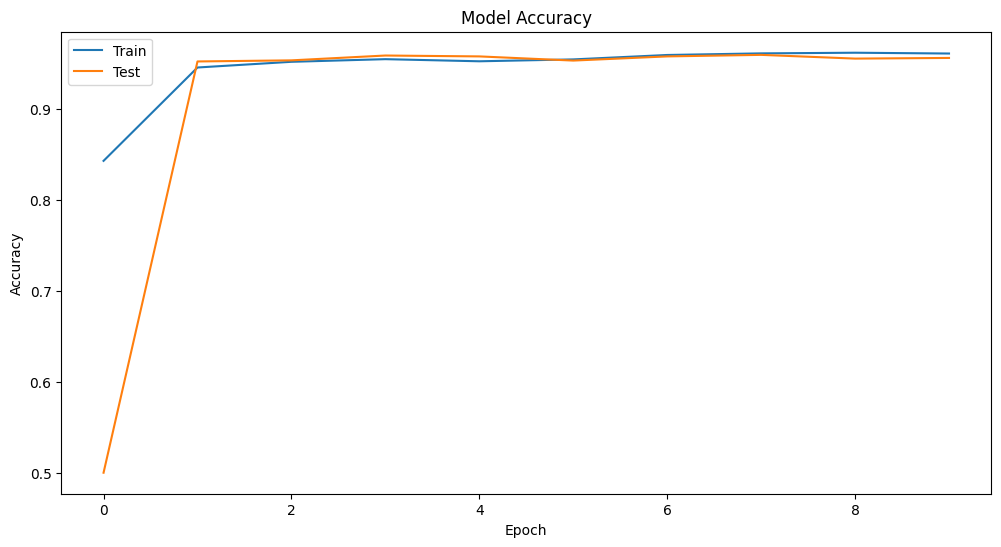

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train','Test'], loc='upper left')
plt.savefig('Acc.jpg')

plt.show()

In [ ]:
#Matrice de confusion
label_head = ['Infecte','Non infecte']

def construct_conf_matrix_report(feature):
    conf_matrix = metrics.confusion_matrix(Y_test, feature, labels=None, sample_weight=None, normalize='true')
    cm_display = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels = label_head)
    rapport = print(classification_report(Y_test, feature))

    fig, ax = plt.subplots(figsize=(7,8))
    ax.grid(False)
    cm_display.plot(ax=ax)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2073
           1       0.93      0.98      0.95      2070

    accuracy                           0.95      4143
   macro avg       0.95      0.95      0.95      4143
weighted avg       0.95      0.95      0.95      4143



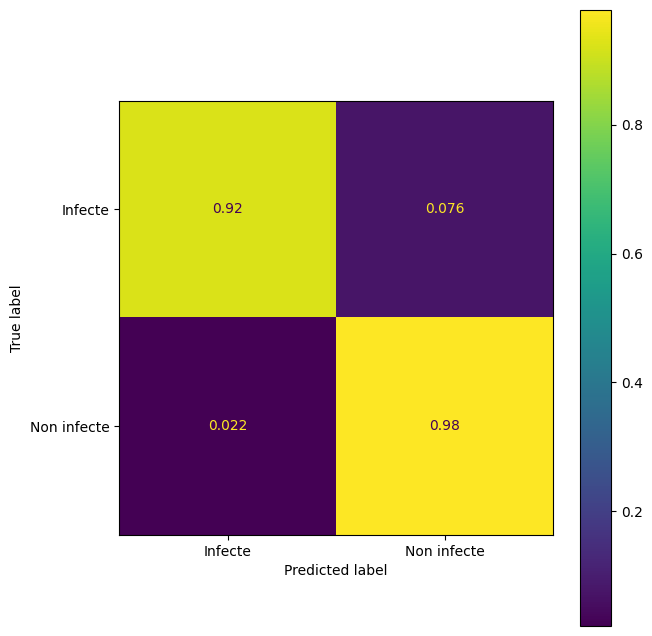

In [ ]:
construct_conf_matrix_report(Y_pred)

In [ ]:
# conf_mat = confusion_matrix(Y_test,Y_pred)
# sns.set_style(style='dark')
# plt.figure(figsize=(12,8))
# heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":20},cmap='Spectral')
# heatmap.set_title('Confusion Matrix Heatmap\n¿Is the cell infected?', fontdict={'fontsize':15}, pad=12)
# heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
# heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
# heatmap.set_xticklabels(['NO','YES'], fontdict={'fontsize':12})
# heatmap.set_yticklabels(['NO','YES'], fontdict={'fontsize':12})
# plt.show()


#print('-Acuracy achieved: {:.2f}%\n-Accuracy by model was: {:.2f}%\n-Accuracy by validation was: {:.2f}%'.
#      format(accuracy_score(Y_test,Y_pred)*100,(history.history['accuracy'][-1])*100,(history.history['val_accuracy'][-1])*100))